示例在Book Crossing数据集的基础上进行图书推荐系统的研究，实现了基于流行度的简单推荐系统和基于协同过滤的推荐系统<p>
示例来源于：
https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### 一、加载数据

数据集中包括三个数据，分别表示users、books和user-book

In [141]:
# 图书数据
books = pd.read_csv('./dataset/BX-Books.csv', header=0, sep=';', error_bad_lines=False, encoding='latin-1')
users = pd.read_csv('./dataset/BX-Users.csv', header=0, sep=';', error_bad_lines=False, encoding='latin-1')
ratings = pd.read_csv('./dataset/BX-Book-Ratings.csv', header=0, sep=';', error_bad_lines=False, encoding='latin-1')
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
print(books.shape)
users.columns = ['userID', 'Location', 'Age']
print(users.shape)
ratings.columns = ['userID', 'ISBN', 'bookRating']
print(ratings.shape)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


(271360, 8)
(278858, 3)
(1149780, 3)


##### 1. books数据探索

In [27]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [28]:
# URL的相关信息应该不是必须的可考虑删除
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'], axis=1, inplace=True)
books.columns.tolist()

['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher']

In [29]:
# 查看数据类型
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

In [30]:
pd.set_option('display.max_colwidth', -1)

###### 1.1 yearOfPublication

(1)对yearOfPublication进行分析，同一个出版日期应当为一个int值<p>
(2)部分数据为int，部分数据为string，需统一<p>
(3)'DK Publishing Inc'和'Gallimard'为错误数据，需清洗

In [31]:
books[''].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [32]:
books.loc[(books['yearOfPublication'] == 'DK Publishing Inc') | (books['yearOfPublication'] == 'Gallimard') ]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [33]:
# 从上可见，Book-Title、Book-Author和Year-Of-Publication的值发生了错乱

#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [34]:
# 重新检测
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X')]
# Done

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc


In [35]:
#ISBN '2070426769'
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [36]:
# 重新检测
books.loc[books.ISBN == '2070426769',:]
# Done

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [37]:
# 修改yearOfPublication值的数据类型为int
books.yearOfPublication = pd.to_numeric(books.yearOfPublication,errors='coerce')

In [38]:
# 从小到大对yearOfPublication进行排序
print(sorted(books.yearOfPublication.unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [39]:
# 考虑到本数据集出版于2016，所以0和超过2016的为错误数据
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

In [44]:
# 对缺失数据用均值进行填充
books['yearOfPublication'].fillna(books.yearOfPublication.mode()[0], inplace=True)

In [46]:
# 检测是否存在空值
books['yearOfPublication'].isnull().sum()
# 无None值

0

In [47]:
# 将数据设为int32
books['yearOfPublication'] = books['yearOfPublication'].astype(np.int32)

###### 1.2 publisher

主要处理publisher的缺失值问题

In [50]:
books[books['publisher'].isnull()]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [52]:
# 观察bookTitle看是否能发现规律
print(books[books['bookTitle']=='Tyrant Moon']['publisher'])
print("*"*10)
print(books[books['bookTitle']=='Finders Keepers']['publisher'])
# 无明显规律

128890    NaN
Name: publisher, dtype: object
**********
10799     Zebra Books                      
42019     McGraw-Hill Companies            
58264     Harpercollins Juvenile Books     
66678     Kensington Publishing Corporation
129037    NaN                              
134309    Voyager Books                    
173473    Red Tower Publications           
195885    HarperTorch                      
211874    Worldwide Library                
Name: publisher, dtype: object


In [53]:
# 观察bookAuthor看是否能发现规律
print(books[books['bookAuthor']=='Elaine Corvidae']['publisher'])
print("*"*10)
print(books[books['bookAuthor']=='Linnea Sinclair']['publisher'])

126762    Novelbooks             
128890    NaN                    
129001    Hard Shell Word Factory
Name: publisher, dtype: object
**********
129037    NaN
Name: publisher, dtype: object


In [54]:
# 均为发现明显规律，用‘other’进行替代
books['publisher']=books['publisher'].fillna('other')

In [55]:
# check
books['publisher'].isnull().sum()

0

##### 2. Users数据探索

In [56]:
print(users.shape)
users.head()

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [57]:
users.dtypes

userID      int64  
Location    object 
Age         float64
dtype: object

###### 2.1 userID

In [58]:
# 无重复值
users[users['userID'].duplicated()]

,userID,Location,Age


In [60]:
# 查看具体指
users['userID'].values

array([     1,      2,      3, ..., 278856, 278857, 278858])

###### 2.2 Age

In [66]:
print(sorted(users['Age'].unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [67]:
# 将年龄小于5岁和大于90岁的均用Nan值替代
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.NAN

In [70]:
# 将Nan用均值代替
users.Age.fillna(users.Age.mean(), inplace=True)
# 将Age改为整型
users.Age = users.Age.astype(np.int32)

In [72]:
# check 
print(users.Age.isnull().sum())
print(sorted(users['Age'].unique()))
# done

0
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


##### 3. Rating数据集探索

In [122]:
ratings.shape

(1149780, 3)

In [79]:
# 若user和book一一配对
users.shape[0] * books.shape[0]
# 可见整个rating数据相对于用户或书籍是非常sparse的

75670906880

In [75]:
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [142]:
# 剔除评分中ISBN不在books的部分和userID不在users中
ratings_new = ratings[ratings['ISBN'].isin(books['ISBN'])]
ratings_new = ratings_new[ratings_new['userID'].isin(users['userID'])]

print(ratings_new.shape)

(1031136, 3)


In [85]:
# 数据的稀疏性
sparsity=1.0-len(ratings_new)/float(users.shape[0] * books.shape[0])
print('The sparsity level of Book Crossing dataset is ' +  str(round(sparsity*100,5)) + ' %')

The sparsity level of Book Crossing dataset is 99.99864 %


In [86]:
# rating中的评分等级
print(sorted(ratings_new['bookRating'].unique()))
# 评分范围为0~10， 其中评分为0的视作隐形评分，对应的用户视作隐性行为用户

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [143]:
# 按照显性和隐性对数据集进行划分
ratings_implicit = ratings_new[ratings_new['bookRating']==0]
ratings_explicit = ratings_new[ratings_new['bookRating']!=0]

users_exp_ratings = users[users.userID.isin(ratings_explicit.userID)]
users_imp_ratings = users[users.userID.isin(ratings_implicit.userID)]

In [144]:
# checking shapes
print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

(1031136, 3)
(383842, 3)
(647294, 3)


In [145]:
# checking shapes
print(users.shape)
print(users_exp_ratings.shape)
print(users_imp_ratings.shape)

(278858, 3)
(68091, 3)
(52451, 3)


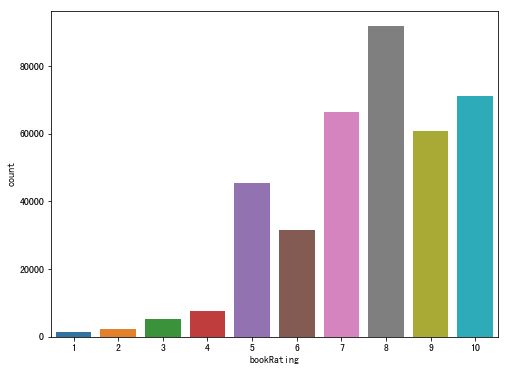

In [95]:
# 绘制评分的分布
plt.figure(figsize=(8,6))
sns.countplot(data=ratings_explicit, x='bookRating')
plt.show()

### 二、推荐系统模块

#### 2.1 简单的流行度推荐

基于不同书籍的用户评分计数来构建基于流行度的简单推荐系统

In [146]:
# 基于总评分
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
print(ratings_count.head())

            bookRating
ISBN                  
0000913154  8         
0001046438  9         
000104687X  6         
0001047213  9         
0001047973  18        


In [147]:
top10 = ratings_count.sort_values(by='bookRating', ascending=False).head(10)
print(top10)

            bookRating
ISBN                  
0316666343  5787      
0385504209  4108      
0312195516  3134      
059035342X  2798      
0142001740  2595      
0971880107  2551      
0060928336  2524      
0446672211  2402      
0452282152  2219      
0671027360  2179      


In [148]:
print("Following books are recommended:")
top10.merge(books, left_index=True, right_on='ISBN')

Following books are recommended:


,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg


#### 2.2 基于协同过滤的推荐系统

为了配合机器的计算能力并减少数据集大小， 我们选择至少对100本书籍进行打分的用户，以及至少有100个评分的评分等级。

In [163]:
ratings_explicit2 = ratings_explicit.copy(deep=True)

In [164]:
# 对用户进行过滤（评分数据大于100）
count1 = ratings_explicit2['userID'].value_counts()
ratings_explicit2 = ratings_explicit2[ratings_explicit2['userID'].isin(count1[count1>=100].index)]

In [167]:
# 对评分进行过滤（评分数量不小于100）
count2 = ratings_explicit2['bookRating'].value_counts()
ratings_explicit2 = ratings_explicit2[ratings_explicit2['bookRating'].isin(count2[count2>=100].index)]

In [169]:
# 根据用户-书籍数据生成透视表
ratings_matrix = ratings_explicit2.pivot(index='userID', columns='ISBN', values='bookRating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
n_users = ratings_matrix.shape[0] #considering only those users who gave explicit ratings
n_books = ratings_matrix.shape[1]
print(n_users, n_books)

449 66574


In [172]:
# 将Nan值填充为0
ratings_matrix.fillna(0, inplace=True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [173]:
#checking first few rows
ratings_matrix.head(5)

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
#rechecking the sparsity
sparsity=1.0-len(ratings_explicit)/float(n_users*n_books)
print('The sparsity level of Book Crossing dataset is ' +  str(sparsity*100) + ' %')

The sparsity level of Book Crossing dataset is 98.71589215022244 %


**训练推荐系统**

In [176]:
# 设定全局变量
global metric, k
k = 10   # 10个近邻
metric = 'cosine'    # 夹角余弦

**基于用户的推荐系统**

In [184]:
# 通过夹角余弦寻找近近似用户
from sklearn.neighbors import NearestNeighbors
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric=metric, algorithm='brute')
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1 - distances.flatten()
    
    return similarities, indices

In [185]:
# 基于用户相似度给指定的user-item进行打分
"""
其基本流程为：
（1）根据user_id搜索最相似的用户群体，即对应相似度
（2）对相似用户的item评分进行均衡处理（防止评分偏差）
（3）对所有用户的评分进行加权和
"""
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction = 0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices = findksimilarusers(user_id, ratings, metric = metric, k=k)
    
    # 当前用户的评分均值
    mean_rating = ratings.iloc[user_loc, :].mean()
    # 各用户的相似权重值
    sum_wt = np.sum(similarities) - 1   # 扣除自己
    product = 1    
    wtd_sum = 0    # 存储根据相似用户求得的和
    
    for i in range(0, len(indices.flatten())):
        if user_loc == indices.flatten()[i]:
            continue
        else:
            # 计算该近似用户item评分进行均衡处理后的值
            ratings_diff = ratings.iloc[indices.flatten()[i], item_loc] - np.mean(ratings.iloc[indices.flatten()[i], :])
            product = ratings_diff * similarities[i]
            wtd_sum += product
            
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
        # 若得到负的或偏大的预测值，需进行特殊处理
    if prediction <= 0:
        prediction = 1
    elif prediction >=10:
        prediction = 10
    print('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction          
        

In [186]:
predict_userbased(11676,'0001056107',ratings_matrix);


Predicted rating for user 11676 -> item 0001056107: 2


**基于物品的推荐系统**

In [187]:
# 寻找k个最近的用品，而把user的评价视作特征
def findksimilaritems(item_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    ratings = ratings.T
    model_knn = NearestNeighbors(metric=metric, algorithm='brute')
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(item_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1 - distances.flatten()
    
    return similarities, indices

In [189]:
similarities,indices=findksimilaritems('0001056107',ratings_matrix)
print(similarities)
print(indices)

[1.         0.99227788 0.87811408 0.73582366 0.70710678 0.70710678
 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678]
[[   10 61360 47739  2053 33935 57128  7952 54358 53915  4915 41173]]


In [190]:
# 基于物品相似度给指定的user-item进行打分
"""
其基本流程为：
（1）根据item_id搜索最相似的item群体，即对应相似度
（2）对item群体对应的评分进行加权和
"""
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings)
    
    sum_wt = np.sum(similarities)-1   # 除去自己
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue
        else: 
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum += product
    
    prediction = int(round(wtd_sum/sum_wt))
    
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10

    print('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction) )     
    
    return prediction

In [191]:
prediction = predict_itembased(11676,'0001056107',ratings_matrix)


Predicted rating for user 11676 -> item 0001056107: 1


In [193]:
np.array_str(ratings_matrix.index.values)

'[  2033   2110   2276   4017   4385   5582   6242   6251   6543   6575\n   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538\n  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966\n  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535\n  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810\n  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299\n  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273\n  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025\n  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220\n  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244\n  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389\n  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223\n  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287\n  83637  83671  85526  85656  86189  86947  87141  87555  88283

### 三、最终整合后的推荐系统

In [209]:
import os, sys
from IPython.display import display, clear_output
import ipywidgets as widgets
from contextlib import contextmanager
import re

In [210]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [211]:
#This function utilizes above functions to recommend items for item/user based approach and cosine/correlation. 
#Recommendations are made if the predicted rating for an item is >= to 6,and the items have not been rated already
def recommendItem(user_id, ratings, metric=metric):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
    else:    
        ids = ['Item-based (correlation)','Item-based (cosine)','User-based (correlation)','User-based (cosine)']
        select = widgets.Dropdown(options=ids, value=ids[0],description='Select approach', width='1000px')
        def on_change(change):
            clear_output(wait=True)
            prediction = []            
            if change['type'] == 'change' and change['name'] == 'value':            
                if (select.value == 'Item-based (correlation)') | (select.value == 'User-based (correlation)') :
                    metric = 'correlation'
                else:                       
                    metric = 'cosine'   
                with suppress_stdout():
                    if (select.value == 'Item-based (correlation)') | (select.value == 'Item-based (cosine)'):
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_itembased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                    else:
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_userbased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                prediction = pd.Series(prediction)
                prediction = prediction.sort_values(ascending=False)
                recommended = prediction[:10]
                print("As per {0} approach....Following books are recommended...".format(select.value))
                for i in range(len(recommended)):
                     print("{0}. {1}".format(i+1,books.bookTitle[recommended.index[i]].encode('utf-8')))                     
        select.observe(on_change)
        display(select)

In [212]:
#checking for incorrect entries
recommendItem(999999,ratings_matrix)

User id should be a valid integer from this list :

   2033   2110   2276   4017   4385   5582   6242   6251   6543   6575
   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538
  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966
  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535
  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810
  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299
  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273
  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025
  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220
  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244
  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389
  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223
  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287
  83637  83671  85526  85

In [217]:
recommendItem(4385, ratings_matrix)

In [216]:
recommendItem(4385, ratings_matrix)